In [1]:
# -*- coding: utf-8 -*-
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

import numpy as np
import matplotlib.pyplot as plt

In [2]:
provider = IBMQ.enable_account('account-id-here')
#provider = IBMQ.load_account()

In [3]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

## Get gates duration
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [4]:
# Get duration of instructions

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
CNOT_durations = dict(CNOT_durations)

tau_cnot01 = CNOT_durations["[0, 1]"]
tau_cnot10 = CNOT_durations["[1, 0]"]
tau_cnot34 = CNOT_durations["[3, 4]"]
tau_cnot43 = CNOT_durations["[4, 3]"]
tau_cnot13 = CNOT_durations["[1, 3]"]

## Define the circuit creation functions

In [5]:
def make_swap_transpiled_circuit(state=0):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])
    
    # Data gate
    tau_data = 0
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)
    
    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    
    # Inverse data gate
    if state==1:
        circuit.x(0)
    elif state=="+":
        circuit.h(0)
    elif state=="-":
        circuit.h(0)
        circuit.x(0)
        
    circuit.measure(0,0)

    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit


def make_swapWithZs_transpiled_circuit(state=0, wait=False):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])

    # Data gate
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)

    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.z([0,1])
    circuit.cnot(0,1)
    circuit.z([0,1])
    circuit.cnot(1,0)
    circuit.z([0,1])
    circuit.cnot(0,1)
    
    if wait==True:
        circuit.z([0,1])
        circuit.delay(CNOT_durations["[1, 0]"], [0, 1], "dt")
        circuit.z([0,1])
        
    # Inverse data gate
    if state==1:
        circuit.x(0)
    elif state=="+":
        circuit.h(0)
    elif state=="-":
        circuit.h(0)
        circuit.x(0)
        
    circuit.measure(0,0)

    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit


def make_swapWithXs_transpiled_circuit(state=0, wait=False):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])

    # Data gate
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)

    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.x([0,1])
    circuit.cnot(0,1)
    circuit.x([0,1])
    circuit.cnot(1,0)
    circuit.x([0,1])
    circuit.cnot(0,1)
    
    if wait==True:
        circuit.x([0,1])
        circuit.delay(CNOT_durations["[1, 0]"], [0, 1], "dt")
        circuit.x([0,1])
        
    # Inverse data gate
    if state==1:
        circuit.x(0)
    elif state=="+":
        circuit.h(0)
    elif state=="-":
        circuit.h(0)
        circuit.x(0)
        
    circuit.measure(0,0)

    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit


def make_2swap_transpiled_circuit(state=0):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])

    # Data gate
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)

    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)

    # Second SWAP gates
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    
    # Inverse data gate
    if state==1:
        circuit.x(1)
    elif state=="+":
        circuit.h(1)
    elif state=="-":
        circuit.h(1)
        circuit.x(1)
        
    circuit.measure(1,0)
    
    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit


def make_2swapWithZs_transpiled_circuit(state=0, wait1=False, wait2=False):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])

    # Data gate
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)

    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.z([0,1])
    circuit.cnot(0,1)
    circuit.z([0,1])
    circuit.cnot(1,0)
    circuit.z([0,1])
    circuit.cnot(0,1)
    
    if wait1==True:
        circuit.z([0,1])
        circuit.delay(CNOT_durations["[1, 0]"], [0, 1], "dt")
    
    # Second SWAP gates.
    circuit.z([0,1])
    circuit.cnot(0,1)
    circuit.z([0,1])
    circuit.cnot(1,0)
    circuit.z([0,1])
    circuit.cnot(0,1)

    if wait2==True:
        circuit.z([0,1])
        circuit.delay(CNOT_durations["[1, 0]"], [0, 1], "dt")
    
    # Inverse data gate
    if state==1:
        circuit.x(1)
    elif state=="+":
        circuit.h(1)
    elif state=="-":
        circuit.h(1)
        circuit.x(1)
        
    circuit.measure(1,0)

    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit


def make_2swapWithXs_transpiled_circuit(state=0, wait1=False, wait2=False):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])

    # Data gate
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)

    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.x([0,1])
    circuit.cnot(0,1)
    circuit.x([0,1])
    circuit.cnot(1,0)
    circuit.x([0,1])
    circuit.cnot(0,1)
    
    if wait1==True:
        circuit.x([0,1])
        circuit.delay(CNOT_durations["[1, 0]"], [0, 1], "dt")
    
    # Second SWAP gates.
    circuit.x([0,1])
    circuit.cnot(0,1)
    circuit.x([0,1])
    circuit.cnot(1,0)
    circuit.x([0,1])
    circuit.cnot(0,1)
    
    if wait2==True:
        circuit.x([0,1])
        circuit.delay(CNOT_durations["[1, 0]"], [0, 1], "dt")
        
    # Inverse data gate
    if state==1:
        circuit.x(1)
    elif state=="+":
        circuit.h(1)
    elif state=="-":
        circuit.h(1)
        circuit.x(1)
        
    circuit.measure(1,0)

    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit

def make_2swap_transpiled_circuit_full(state=0):
    
    # With data decodification
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)

    #circuit.reset([0,1,3,4])

    # Data gate
    if state==1:
        tau_data = X_duration
        circuit.x(1)
    elif state=="+":
        tau_data = H_duration
        circuit.h(1)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(1)
        circuit.h(1)

    circuit.barrier(q)
    
    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    
    # Second SWAP gates
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)

    # Inverse data gate
    if state==1:
        circuit.x(1)
    elif state=="+":
        circuit.h(1)
    elif state=="-":
        circuit.h(1)
        circuit.x(1)
        
    circuit.measure(1,0)

    tcircuit = transpile(circuit, backend, scheduling_method="asap", optimization_level=0)
    
    return tcircuit


**For checking that the circuit creation functions make the circuits correctly**

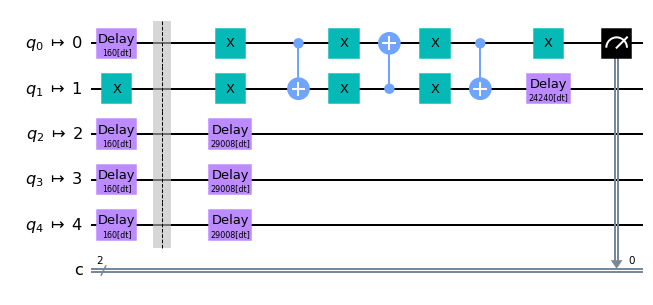

In [8]:
state = 1
wait=True
wait1=True
wait2=True

#tcircuit = make_2swap_transpiled_circuit(state=state)#, wait1=wait1, wait2=wait2)
tcircuit = make_swapWithXs_transpiled_circuit(state=state)#, wait=wait)

tcircuit.draw("mpl", fold=-1)

## Build the circuits

In [11]:
repetitions = 50
states = [0, 1, "+", "-"]
transpiled_circuits = []
shots = 2**13 #8912

cases = ["1swap", "1swap-z", "1swap-z-delay", "1swap-x", "1swap-x-delay",
         "2swap", "2swap-z", "2swap-z-delay", "2swap-x", "2swap-x-delay"]
# 10 cases

# 1 swap
for state in states:
    transpiled_circuits = transpiled_circuits + [make_swap_transpiled_circuit(state)]*repetitions
    
# 1 swap - z 
for state in states:
    transpiled_circuits = transpiled_circuits + [make_swapWithZs_transpiled_circuit(state)]*repetitions

# 1 swap - z - delay
for state in states:
    transpiled_circuits = transpiled_circuits + [make_swapWithZs_transpiled_circuit(state, wait=True)]*repetitions    
    
# 1 swap - x 
for state in states:
    transpiled_circuits = transpiled_circuits + [make_swapWithXs_transpiled_circuit(state)]*repetitions
    
# 1 swap - x - delay
for state in states:
    transpiled_circuits = transpiled_circuits + [make_swapWithXs_transpiled_circuit(state, wait=True)]*repetitions

# 2 swap
for state in states:
    transpiled_circuits = transpiled_circuits + [make_2swap_transpiled_circuit(state)]*repetitions

# 2 swap - z 
for state in states:
    transpiled_circuits = transpiled_circuits + [make_2swapWithZs_transpiled_circuit(state)]*repetitions

# 2 swap - z - delay
for state in states:
    transpiled_circuits = transpiled_circuits + [make_2swapWithZs_transpiled_circuit(state, wait1=True, wait2=True)]*repetitions

# 2 swap - x 
for state in states:
    transpiled_circuits = transpiled_circuits + [make_2swapWithXs_transpiled_circuit(state)]*repetitions

# 2 swap - x - delay
for state in states:
    transpiled_circuits = transpiled_circuits + [make_2swapWithXs_transpiled_circuit(state, wait1=True, wait2=True)]*repetitions

## Send the job set to IBM

In [ ]:
job_manager = IBMQJobManager()
job_set = job_manager.run(transpiled_circuits, backend=backend, name="1qubitSwapTests_allCases_q0q1", shots=shots)
#job_monitor(job_set)

**For saving the job_set id for being able to retrieve it in the future.**

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

**For checking the job status.**

In [ ]:
job_set.statuses()

## Define the fidelity function

In [9]:
def fidelity(state, counts, shots):
    
    counts = np.asarray(counts)
    
    if state == 0:
        f = (np.asarray(counts[0][0]))/shots
    
    elif state == 1:
        f = (np.asarray(counts[1][0]))/shots
    
    elif state == "+":
        f = (np.asarray(counts[2][0]))/shots
        
    elif state == "-":
        f = (np.asarray(counts[3][0]))/shots
    
    return f

## Retrieve the job_set

In [12]:
repetitions = 50
shots = 2**13
reshape_dims_circs = (10, 4, repetitions, 2)

job_manager = IBMQJobManager()
job_id = "job-set-id-here"
print("Getting job...")
job_set = job_manager.retrieve_job_set(job_id, provider)
print("Getting results...")
results_all = job_set.results()
print("Processing counts...")
all_counts_array = np.array([list(results_all.get_counts(i).values()) for i in range(10*4*repetitions)])
all_counts_array = [all_counts_array.reshape(reshape_dims_circs)[:5], # k=0 (1swap) 
                    all_counts_array.reshape(reshape_dims_circs)[5:]] # k=1 (2swap)
print("Done!")

Getting job...
Getting results...
Processing counts...
Done!


## Plot the results

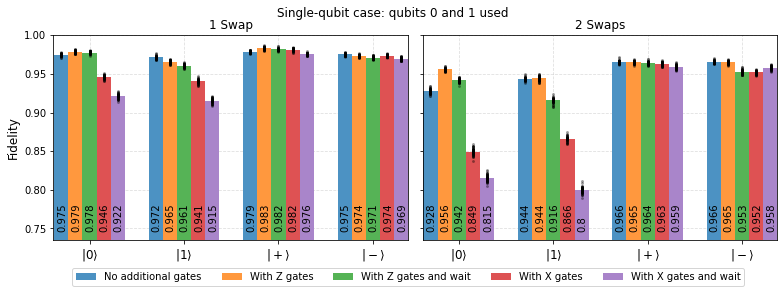

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4), sharey=True)

data_labels = ["No additional gates", "With Z gates", "With Z gates and wait", "With X gates", "With X gates and wait", "Bell undone"]
labels = ["$|0\\rangle$", "$|1\\rangle$", "$|+\\rangle$", "$|-\\rangle$"]
colors = ["C0", "C1", "C2", "C3", "C4"]
width = 0.3 # Width of the bars

x = np.arange(len(labels))*2 # For positioning the bars


for k in range(2):
    for i, counts_array in enumerate(all_counts_array[k]):

        xrange = x[-1] + 2*(width+0.4)
        
        if k==0:
            axs[k].set_title("1 Swap")
            axs[k].set_ylabel("Fidelity", fontsize=12)
        elif k==1:
            axs[k].set_title("2 Swaps")

        # Get the counts for the current initial state
        raw_counts_0 = [counts_array[0][:,i] for i in range(2)]
        raw_counts_1 = [counts_array[1][:,i] for i in range(2)]
        raw_counts_p = [counts_array[2][:,i] for i in range(2)]
        raw_counts_m = [counts_array[3][:,i] for i in range(2)]
        raw_counts = [raw_counts_0, raw_counts_1, raw_counts_p, raw_counts_m]
    
        # Get the average of the repetitions
        counts_0 = [np.round(np.average(counts_array[0][:,i])).astype(int) for i in range(2)]
        counts_1 = [np.round(np.average(counts_array[1][:,i])).astype(int) for i in range(2)]
        counts_p = [np.round(np.average(counts_array[2][:,i])).astype(int) for i in range(2)]
        counts_m = [np.round(np.average(counts_array[3][:,i])).astype(int) for i in range(2)]
        counts = [counts_0, counts_1, counts_p, counts_m]

        # Get the maximum count values of the repetitions
        max_counts_0 = [np.max(counts_array[0][:,i]) for i in range(2)]
        max_counts_1 = [np.max(counts_array[1][:,i]) for i in range(2)]
        max_counts_p = [np.max(counts_array[2][:,i]) for i in range(2)]
        max_counts_m = [np.max(counts_array[3][:,i]) for i in range(2)]
        max_counts = [max_counts_0, max_counts_1, max_counts_p, max_counts_m]

        # Get the minimum count values of the repetitions
        min_counts_0 = [np.min(counts_array[0][:,i]) for i in range(2)]
        min_counts_1 = [np.min(counts_array[1][:,i]) for i in range(2)]
        min_counts_p = [np.min(counts_array[2][:,i]) for i in range(2)]
        min_counts_m = [np.min(counts_array[3][:,i]) for i in range(2)]
        min_counts = [min_counts_0, min_counts_1, min_counts_p, min_counts_m]

        #print("Plotting job...")
        #ax.set_title(ax_titles[i])

        # Get the fidelities
        fidelities = []
        for j in range(4):
            fidelities.append(fidelity(states[j], counts, shots))

        # For placing the bars
        if i == 0:
            xi = x - 2*width
        elif i == 1:
            xi = x - width
        elif i == 2:
            xi = x
        elif i == 3:
            xi = x + width
        elif i == 4:
            xi = x + 2*width

        barplot = axs[k].bar(xi, fidelities, color="white", alpha=1, zorder=5, width=width)
        barplot = axs[k].bar(xi, fidelities, color=colors[i], alpha=0.8, zorder=10, width=width,
                         error_kw={"color":"black", "capsize":5, "alpha":0.7}, label=data_labels[i])

        # Plot the black points, the fidelity of each repetition
        for j in range(4):
            fidelity_j = fidelity(states[j], raw_counts, shots)
            xfid = np.ones(len(fidelity_j))*xi[j]
            axs[k].scatter(xfid, fidelity_j, color="black", s=8, marker="o", alpha=0.4, facecolor="k", edgecolors="k", zorder=26, linewidths=0)

        # https://moonbooks.org/Articles/How-to-add-text-on-a-bar-with-matplotlib-/
        for idx, rect in enumerate(barplot):
            height = rect.get_height()
            x_txt = rect.get_x() + rect.get_width()/1.8 #+ 0.32#0.225
            y_txt = 0.745 #1.05*height
            txt = np.round(fidelities[idx], 3)
            axs[k].text(x_txt , y_txt, txt, ha='center', va='bottom', rotation=90, zorder=30, color="k", fontweight="medium")

    axs[k].set_xlim((-width-0.465,x[-1]+width+0.445))
    axs[k].set_ylim((0.735,1))
    axs[k].set_xticks(x, labels, fontsize=12)
    axs[k].grid(ls="--", alpha=0.4, zorder=0)
    for k, spine in axs[k].spines.items():  #ax.spines is a dictionary
        spine.set_zorder(50)

# Make the plot legend
legendEntries = data_labels
h1, l1 = axs[0].get_legend_handles_labels()
h2, l2 = axs[1].get_legend_handles_labels()
# Set figure legend entries, number of columns, location
fig.legend(h2, legendEntries, ncol=len(legendEntries), loc="lower center", bbox_to_anchor=(0.52, 0.02))

plt.tight_layout()

# Shrink the subplots to make room for the legend
box = axs[0].get_position()
axs[0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
box = axs[1].get_position()
axs[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
fig.suptitle("Single-qubit case: qubits 0 and 1 used", y=1.005)
plt.show()
#plt.savefig(r"lima_1and2swapFidelityTest_8192Shots_50Reps_singleQubitq0q1_12082022.pdf")